# About skip-thought vectors
Article: http://arxiv.org/abs/1506.06726 

Code : https://github.com/ryankiros/skip-thoughts

Dataset : https://archive.ics.uci.edu/ml/datasets/Sentence+Classification

In [129]:
%matplotlib inline
import matplotlib.pyplot as plt
import skipthoughts
from bhtsne import bhtsne as bh
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from os import listdir, walk
import mpld3
mpld3.enable_notebook()
from os.path import isfile, join
from gensim.models import Word2Vec
import nltk

In [2]:
# st_model will contain the pretrained weights for the encoder, and the word vectors
st_model = skipthoughts.load_model() 

# we will compare skip-thought vectors with a vanilla sum of word2vec
w2v = Word2Vec.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) 

Loading model parameters...
Compiling encoders...
Loading tables...
Packing up...


/home/ubuntu/venv/src/theano/theano/scan_module/scan.py:1019: Warning: In the strict mode, all neccessary shared variables must be passed as a part of non_sequences
  'must be passed as a part of non_sequences', Warning)


In [55]:
path = '/mnt/data/skip-thoughts/SentenceCorpus/unlabeled_articles'
filepaths = []
for (dirpath, dirnames, filenames) in walk(path):
    for name in filenames:
        if name[-4:] == '.txt':
            filepaths = filepaths+ [join(dirpath, name)]
            
labelmap = {'arxiv_unlabeled':0,
            'jdm_unlabeled':1,
            'plos_unlabeled':2
           }            
labels = []
sentences = []
for fpath in filepaths:
    with open(fpath, 'r') as f:
        label = np.zeros((3,))
        label[labelmap[fpath.split('/')[-2]]] = 1
        filesentences = []
        for s in f.read().split('\n'):
            if len(s.split(' '))>3: #Let us not keep short sentences
                try:
                    #The dataset contains some shitty data due to mistakes in extraction 
                    filesentences += [u'{}'.format(s)] 
                except:
                    continue
        L = len(filesentences)
        labels += L*[label]
        sentences += filesentences
sentences = np.array(sentences)
labels = np.array(labels)

We'll keep only n_sents random elements, but we could keep them all if we had time and RAM. The more sentences we have, the better our t-SNE will be...

In [56]:
n_sents = 2000
np.random.seed(1234)
indexes = np.arange(len(sentences))
np.random.shuffle(indexes)
sentences = sentences[indexes[:n_sents]]
labels = labels[indexes[:n_sents]]
print sentences.shape,labels.shape

(2000,) (2000, 3)


Here we compute our vanilla representation. Each sentence is represented by the sum of the word vector of all the words in the sentence.

In [57]:
w2v_vectors = []
for sent in sentences:
    words = nltk.word_tokenize(sent)
    vec = np.zeros((300,))
    for w in words:
        try:
            vec += w2v[w]
        except:
            continue
    w2v_vectors += [vec]
w2v_vectors = np.array(w2v_vectors)
print len(sentences), w2v_vectors.shape
del w2v

2000 (2000, 300)


Each sentence is represented by its skip-thought vector

In [138]:
st_vectors = skipthoughts.encode(st_model, sentences)
del st_model

Then, we compute the t-SNE vectors for each representation.

In [61]:
st_tsne = bh.bh_tsne(samples=st_vectors)
st_tsne = list(st_tsne)
st_tsne = np.array(st_tsne)
w2v_tsne = bh.bh_tsne(samples=w2v_vectors)
w2v_tsne = list(w2v_tsne)
w2v_tsne = np.array(w2v_tsne)

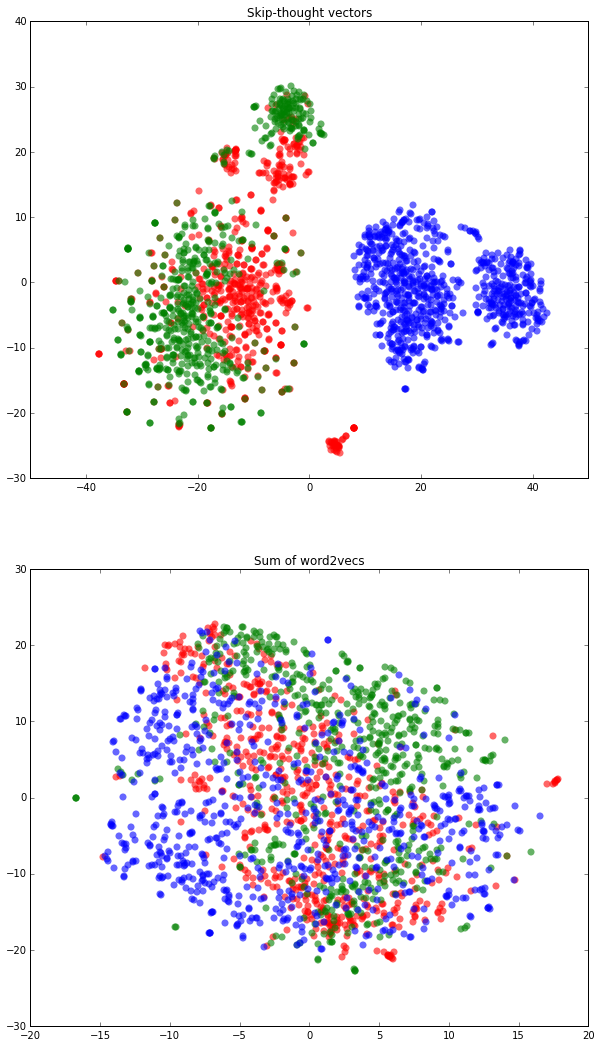

In [140]:
colors = ['r','g','b']

fig = plt.figure(figsize=(10,18))
st_ax = fig.add_subplot(211, autoscale_on=True, title='Skip-thought vectors')
w2v_ax = fig.add_subplot(212, autoscale_on=True, title='Sum of word2vecs')

for k,v in labelmap.items():
    st_X = st_tsne[labels[:,v]==1]
    w2v_X = w2v_tsne[labels[:,v]==1]
    st_scatter = st_ax.scatter(st_X[:,0],
                               st_X[:,1],
                               marker='o',
                               c=colors[v], linewidth = 0,
                               s=50, alpha=.6)
    w2v_scatter = w2v_ax.scatter(w2v_X[:,0],
                               w2v_X[:,1],
                               marker='o',
                               c=colors[v], linewidth = 0,
                               s=50, alpha=.6)
    
    st_scatter.set_label(k)
    w2v_scatter.set_label(k)
    
    st_tooltip = mpld3.plugins.PointLabelTooltip(st_scatter, 
                                                 labels=[u'{}: {}...{}'.format(i,
                                                                               s[:20], 
                                                                               s[-20:]) for i,s in enumerate(sentences)],
                                                 hoffset=10, voffset=20
                                                )
    w2v_tooltip = mpld3.plugins.PointLabelTooltip(w2v_scatter, 
                                                 labels=[u'{}: {}...{}'.format(i,
                                                                               s[:20], 
                                                                               s[-20:]) for i,s in enumerate(sentences)],
                                                 hoffset=10, voffset=20
                                                )
    
    mpld3.plugins.connect(fig, st_tooltip)
    mpld3.plugins.connect(fig, w2v_tooltip)
plt.show()